In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


In [53]:
sns.set(style="whitegrid")
dataset_path = "/content/drive/MyDrive/personal expiry/Medicine_Details.csv"
df = pd.read_csv(dataset_path)
print(f"Loaded dataset with shape: {df.shape}")

Loaded dataset with shape: (11825, 9)


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11825 entries, 0 to 11824
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Medicine Name       11825 non-null  object
 1   Composition         11825 non-null  object
 2   Uses                11825 non-null  object
 3   Side_effects        11825 non-null  object
 4   Image URL           11825 non-null  object
 5   Manufacturer        11825 non-null  object
 6   Excellent Review %  11825 non-null  int64 
 7   Average Review %    11825 non-null  int64 
 8   Poor Review %       11825 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 831.6+ KB


In [55]:
df.head()

,Medicine Name,Composition,Uses,Side_effects,Image URL,Manufacturer,Excellent Review %,Average Review %,Poor Review %
0,Avastin 400mg Injection,Bevacizumab (400mg),Cancer of colon and rectum Non-small cell lun...,Rectal bleeding Taste change Headache Noseblee...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Roche Products India Pvt Ltd,22,56,22
1,Augmentin 625 Duo Tablet,Amoxycillin (500mg) + Clavulanic Acid (125mg),Treatment of Bacterial infections,Vomiting Nausea Diarrhea Mucocutaneous candidi...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Glaxo SmithKline Pharmaceuticals Ltd,47,35,18
2,Azithral 500 Tablet,Azithromycin (500mg),Treatment of Bacterial infections,Nausea Abdominal pain Diarrhea,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Alembic Pharmaceuticals Ltd,39,40,21
3,Ascoril LS Syrup,Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...,Treatment of Cough with mucus,Nausea Vomiting Diarrhea Upset stomach Stomach...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Glenmark Pharmaceuticals Ltd,24,41,35
4,Aciloc 150 Tablet,Ranitidine (150mg),Treatment of Gastroesophageal reflux disease (...,Headache Diarrhea Gastrointestinal disturbance,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Cadila Pharmaceuticals Ltd,34,37,29


In [56]:
# Step 1: Data Preprocessing
# Clean Composition
# removes patterns like (500mg/ml), (5mg), (250.5mg/ml)
def clean_composition(text):
    text = re.sub(r'\(\d*\.?\d*mg[/ml]*\)', '', text)
    text = text.replace('+', ' ').lower().strip()
    return text

df['Composition_clean'] = df['Composition'].apply(clean_composition)

In [57]:
# Clean Side_effects
def clean_side_effects(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    words = text.lower().split()
    side_effects = [w for w in words if 3 <= len(w) <= 20 and not w.isdigit()]
    return side_effects

df['Side_effects_clean'] = df['Side_effects'].apply(clean_side_effects)

In [58]:
# Computing side effect frequencies
side_effect_counts = Counter()
df['Side_effects_clean'].apply(lambda x: side_effect_counts.update(x))
print(f"Total unique side effects: {len(side_effect_counts)}")
print(f"Top 20 side effects by frequency: {side_effect_counts.most_common(20)}")

Total unique side effects: 773
Top 20 side effects by frequency: [('pain', 6383), ('nausea', 6216), ('headache', 5374), ('diarrhea', 4553), ('blood', 4156), ('dizziness', 4064), ('vomiting', 3499), ('increased', 2869), ('stomach', 2362), ('skin', 2237), ('abdominal', 2232), ('level', 2034), ('and', 2020), ('itching', 2018), ('site', 1816), ('rash', 1792), ('sleepiness', 1792), ('constipation', 1699), ('irritation', 1641), ('redness', 1583)]


In [59]:
# 1,512 -> 773 ->510 ->284->148
# Filter high-frequency side effects (>=200 occurrences)
min_freq = 200
frequent_side_effects = {se for se, count in side_effect_counts.items() if count >= min_freq}
print(f"Side effects with >= {min_freq} occurrences: {len(frequent_side_effects)}")

Side effects with >= 200 occurrences: 148


In [60]:
# Apply frequency filter
df['Side_effects_filtered'] = df['Side_effects_clean'].apply(
    lambda x: [se for se in x if se in frequent_side_effects]
)

# Synonym mapping
side_effect_mapping = {
    'nausea': 'nausea',
    'vomiting': 'nausea',
    'diarrhea': 'diarrhea',
    'diarrhoea': 'diarrhea',
    'headache': 'headache',
    'dizziness': 'dizziness',
    'fatigue': 'fatigue',
    'tiredness': 'fatigue',
    'rash': 'rash',
    'itching': 'itching',
    'itch': 'itching',
    'pain': 'pain',
    'abdominal': 'pain',
    'stomach': 'pain',
    'constipation': 'constipation',
    'sleepiness': 'sleepiness',
    'irritation': 'rash',
    'redness': 'rash',
    'bleeding': 'bleeding',
    'hemorrhage': 'bleeding',
    'dryness': 'dry skin',
    'dry': 'dry skin',
    'edema': 'edema',
    'swelling': 'edema',
    'fever': 'fever',
    'infection': 'infection',
    'depression': 'depression',
    'ulcer': 'ulcer',
    'blisters': 'rash',
    'flashes': 'hot flashes',
    'menstrual': 'menstrual irregularity',
    'blood': None,
    'increased': None,
    'level': None,
    'and': None,
    'site': None,
    'application': None,
    'reaction': None,
    'pressure': None,
    'neutrophils': None,
    'data': None,
    'diabetes': None,
    'intolerance': None,
    'limited': None,
    'symptoms': None,
    'side': None,
    'bone': None,
    'epigastric': 'pain',
    'phlebitis': None,
    'breast': None,
    'neck': 'pain',
    'urine': None,
    'hypertonia': 'muscle stiffness',
    'lipodystrophy': None,
    'cushing': None,
    'telangiectasia': 'rash',
    'paying': None,
    'alanine': None,
    'levels': None,
    'pancreatic': None,
    'aminotransferase': None,
    'insulin': None,
    'accommodation': None,
    'tone': None,
    'iris': None,
    'bitter': None,
    'adrenal': None,
    'ocular': None,
    'hunger': None,
    'fat': None,
    'low': None,
    'rate': None,
    'intense': None,
    'yawning': 'fatigue',
    'ecchymosis': 'bleeding',
    'apnea': None,
    'lymphocytes': None,
    'ovary': None,
    'calcium': None,
    'and':None,
    'site':None,
    'increased':None,
    'the':None,
    'decreased':None,
    'level':None,
    'application':None,

}

In [61]:
# Apply mapping
df['Side_effects_mapped'] = df['Side_effects_filtered'].apply(
    lambda x: [side_effect_mapping.get(se, se) for se in x if side_effect_mapping.get(se, se) is not None]
)

# Check final unique side effects
unique_side_effects = set()
df['Side_effects_mapped'].apply(lambda x: unique_side_effects.update(x))
print(f"Unique side effects after mapping: {len(unique_side_effects)}")
print(f"Sample side effects: {list(unique_side_effects)[:20:-1]}")

Unique side effects after mapping: 123
Sample side effects: ['cough', 'taste', 'change', 'dizziness', 'pain', 'ejaculation', 'skin', 'ankle', 'flu', 'reactions', 'movements', 'changes', 'inflammation', 'cell', 'cramp', 'hypotension', 'depression', 'tingling', 'peeling', 'blurred', 'dysfunction', 'injection', 'cells', 'tests', 'burning', 'face', 'itching', 'white', 'edema', 'extremities', 'anemia', 'back', 'ears', 'gastrointestinal', 'weakness', 'glucose', 'count', 'throat', 'nervousness', 'vaginal', 'potassium', 'breathlessness', 'mouth', 'palpitations', 'slow', 'infection', 'fatigue', 'heart', 'anxiety', 'number', 'vertigo', 'tremors', 'abnormal', 'weight', 'gain', 'rash', 'flushing', 'indigestion', 'discomfort', 'constipation', 'sleepiness', 'sweating', 'nausea', 'sore', 'bloating', 'nasal', 'passages', 'upper', 'congestion', 'eye', 'appetite', 'uncoordinated', 'sudden', 'trunk', 'red', 'heartburn', 'enzymes', 'upset', 'insomnia', 'chest', 'stinging', 'sense', 'urinary', 'hair', 'dry

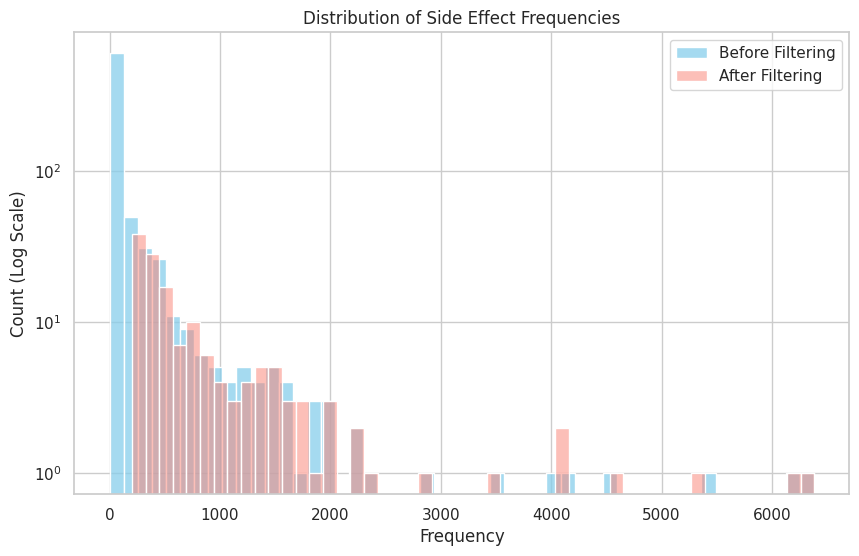

In [62]:
plt.figure(figsize=(10, 6))
sns.histplot(all_counts, bins=50, color='skyblue', label='Before Filtering')
sns.histplot(filtered_counts, bins=50, color='salmon', alpha=0.5, label='After Filtering')
plt.yscale('log')
plt.title('Distribution of Side Effect Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Count (Log Scale)')
plt.legend()
plt.show()


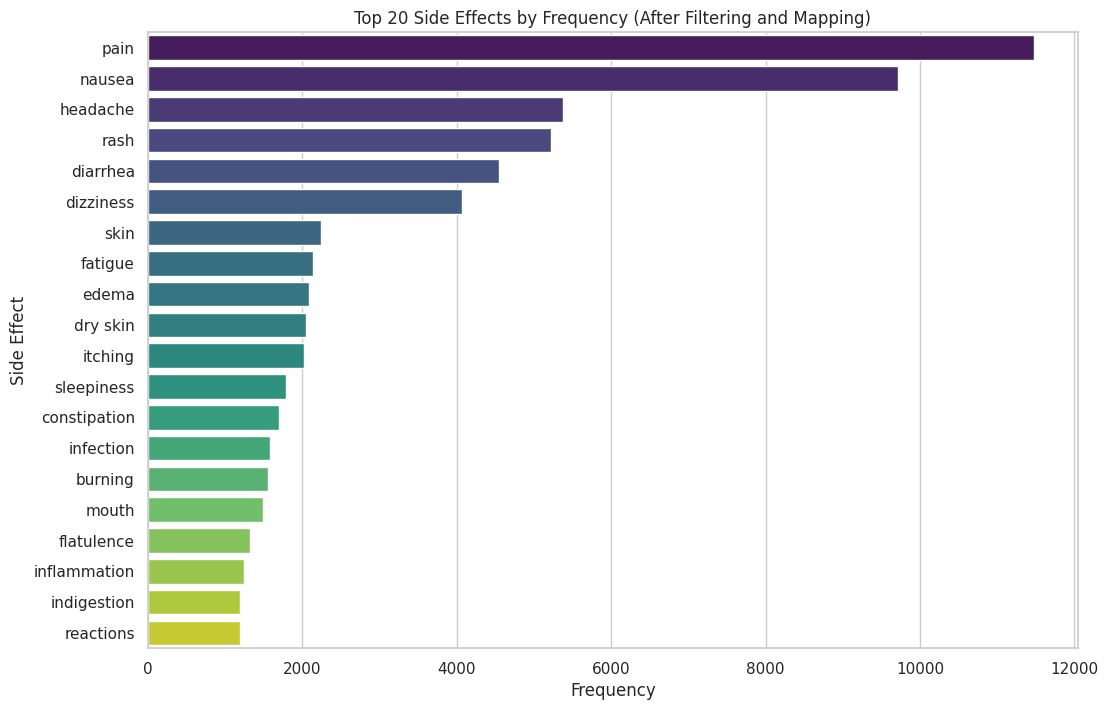

In [63]:
# Visualization 2: Top Side Effects Bar Plot (Fixed)
# Compute frequencies after mapping
mapped_counts = Counter()
df['Side_effects_mapped'].apply(lambda x: mapped_counts.update(x))
top_n = 20
top_side_effects = mapped_counts.most_common(top_n)
top_labels = [se for se, _ in top_side_effects]
top_counts = [count for _, count in top_side_effects]

plt.figure(figsize=(12, 8))
sns.barplot(x=top_counts, y=top_labels, palette='viridis')
plt.title(f'Top {top_n} Side Effects by Frequency (After Filtering and Mapping)')
plt.xlabel('Frequency')
plt.ylabel('Side Effect')
plt.savefig('top_side_effects_fixed.png')
plt.show()

In [64]:
# Encode side effects
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Side_effects_mapped'])
print(f"Number of side effect labels: {y.shape[1]}")

Number of side effect labels: 123


In [65]:
# Feature extraction for Composition
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X = tfidf.fit_transform(df['Composition_clean']).toarray()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Training set shape: (9460, 500), Test set shape: (2365, 500)


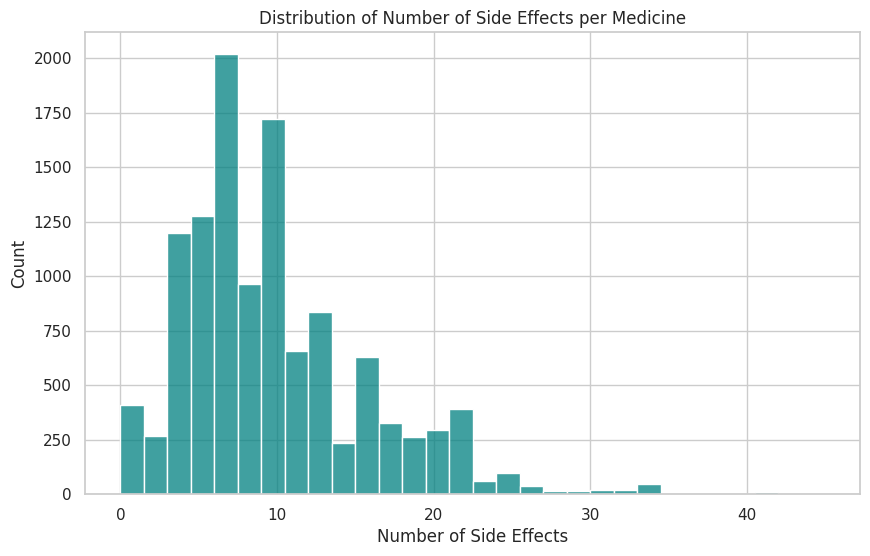

In [66]:
# Visualization 3: Label Distribution per Sample
label_counts = [len(labels) for labels in df['Side_effects_mapped']]
plt.figure(figsize=(10, 6))
sns.histplot(label_counts, bins=30, color='teal')
plt.title('Distribution of Number of Side Effects per Medicine')
plt.xlabel('Number of Side Effects')
plt.ylabel('Count')
plt.savefig('label_distribution_per_sample.png')
plt.show()

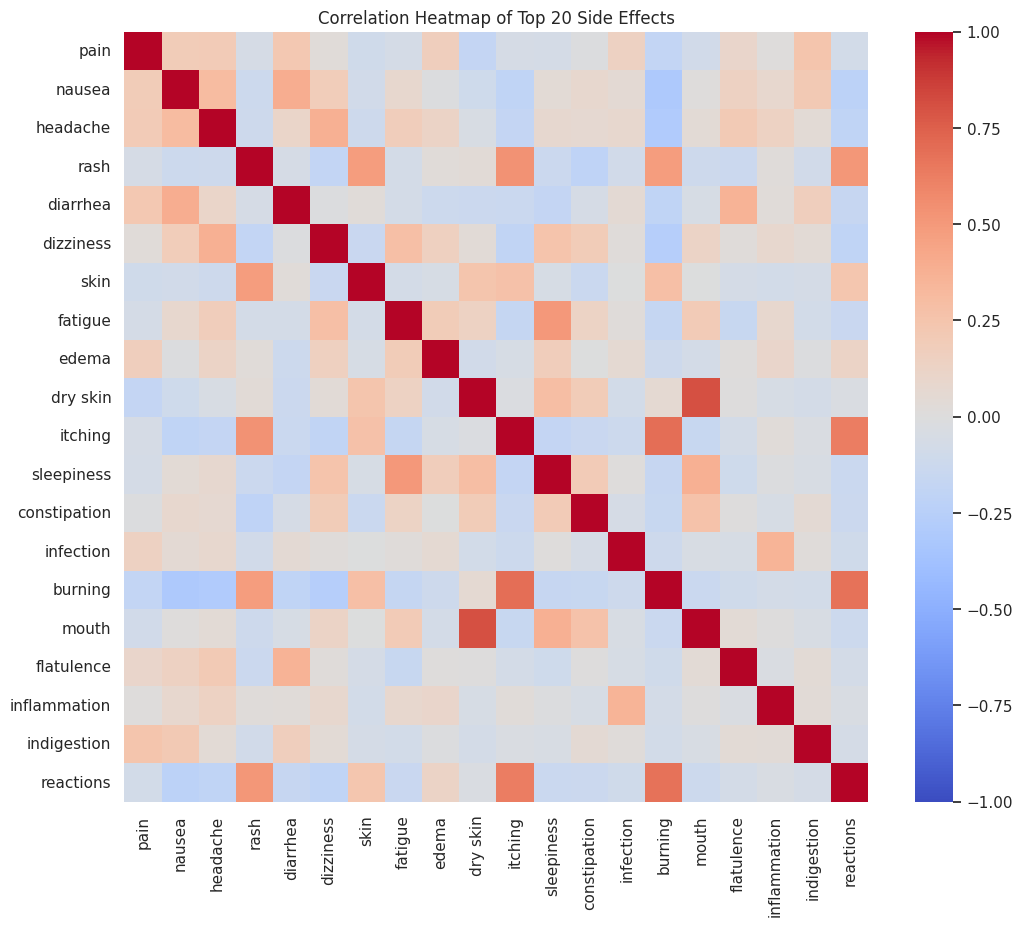

In [67]:
# Visualization 4: Correlation Heatmap of Side Effects
# Compute correlation matrix for top 20 side effects
top_labels_encoded = mlb.transform(df['Side_effects_mapped'])
top_labels_df = pd.DataFrame(top_labels_encoded, columns=mlb.classes_)
# Select top 20 frequent side effects after mapping
mapped_counts = Counter()
df['Side_effects_mapped'].apply(lambda x: mapped_counts.update(x))
top_mapped = [se for se, _ in mapped_counts.most_common(20)]
top_labels_df = top_labels_df[top_mapped]
corr_matrix = top_labels_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Top 20 Side Effects')
plt.savefig('side_effect_correlation_heatmap.png')
plt.show()

In [68]:
# Step 2: Model Training
svm = OneVsRestClassifier(LinearSVC(C=1, random_state=42))
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1))

print("Training SVM...")
svm_best = svm.fit(X_train, y_train)

print("Training Random Forest...")
rf_best = rf.fit(X_train, y_train)

def build_nn(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(output_dim, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("Training Neural Network...")
nn_model = build_nn(X_train.shape[1], y_train.shape[1])
nn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

Training SVM...
Training Random Forest...
Training Neural Network...
Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0134 - loss: 0.4265 - val_accuracy: 0.0063 - val_loss: 0.1962
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0178 - loss: 0.2001 - val_accuracy: 0.0063 - val_loss: 0.1844
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0327 - loss: 0.1836 - val_accuracy: 0.0745 - val_loss: 0.1547
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0807 - loss: 0.1572 - val_accuracy: 0.0862 - val_loss: 0.1326
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0962 - loss: 0.1406 - val_accuracy: 0.1321 - val_loss: 0.1196


In [69]:
# Step 3: Evaluation
svm_pred = svm_best.predict(X_test)
rf_pred = rf_best.predict(X_test)
nn_pred = (nn_model.predict(X_test) > 0.5).astype(int)

svm_f1 = f1_score(y_test, svm_pred, average='micro')
svm_acc = accuracy_score(y_test, svm_pred)
rf_f1 = f1_score(y_test, rf_pred, average='micro')
rf_acc = accuracy_score(y_test, rf_pred)
nn_f1 = f1_score(y_test, nn_pred, average='micro')
nn_acc = accuracy_score(y_test, nn_pred)
ensemble_pred = np.array((svm_pred + rf_pred + nn_pred) >= 2).astype(int)
ensemble_f1 = f1_score(y_test, ensemble_pred, average='micro')
ensemble_acc = accuracy_score(y_test, ensemble_pred)

print("\nSVM Performance:")
print(f"F1-Score (micro): {svm_f1:.4f}")
print(f"Accuracy: {svm_acc:.4f}")

print("\nRandom Forest Performance:")
print(f"F1-Score (micro): {rf_f1:.4f}")
print(f"Accuracy: {rf_acc:.4f}")

print("\nNeural Network Performance:")
print(f"F1-Score (micro): {nn_f1:.4f}")
print(f"Accuracy: {nn_acc:.4f}")

print("\nEnsemble Performance:")
print(f"F1-Score (micro): {ensemble_f1:.4f}")
print(f"Accuracy: {ensemble_acc:.4f}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

SVM Performance:
F1-Score (micro): 0.8640
Accuracy: 0.5712

Random Forest Performance:
F1-Score (micro): 0.7604
Accuracy: 0.3150

Neural Network Performance:
F1-Score (micro): 0.5583
Accuracy: 0.1015

Ensemble Performance:
F1-Score (micro): 0.7870
Accuracy: 0.3442


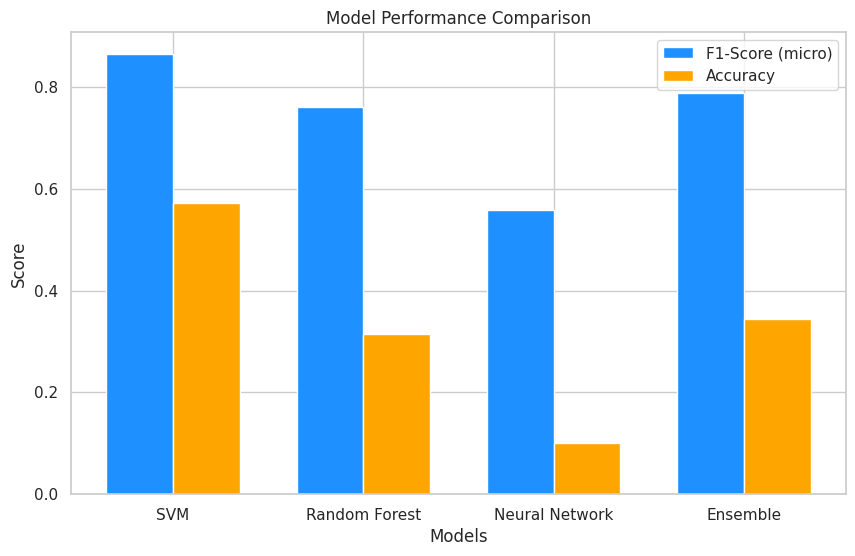

In [70]:
# Visualization 5: Model Performance Comparison
models = ['SVM', 'Random Forest', 'Neural Network', 'Ensemble']
f1_scores = [svm_f1, rf_f1, nn_f1, ensemble_f1]
accuracies = [svm_acc, rf_acc, nn_acc, ensemble_acc]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(models))
plt.bar(index, f1_scores, bar_width, label='F1-Score (micro)', color='dodgerblue')
plt.bar(index + bar_width, accuracies, bar_width, label='Accuracy', color='orange')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(index + bar_width / 2, models)
plt.legend()
plt.savefig('model_performance_comparison.png')
plt.show()

In [71]:
# Step 4: Test with Sample Entry
sample_composition = "Amoxycillin + Clavulanic Acid"
sample_clean = clean_composition(sample_composition)
sample_tfidf = tfidf.transform([sample_clean]).toarray()
sample_pred = svm_best.predict(sample_tfidf)
predicted_side_effects = mlb.inverse_transform(sample_pred)
print(f"\nSample Input: {sample_composition}")
print(f"Predicted Side Effects: {predicted_side_effects[0]}")


Sample Input: Amoxycillin + Clavulanic Acid
Predicted Side Effects: ('diarrhea', 'nausea')


In [72]:
#Save models
import joblib
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(mlb, 'mlb.pkl')
joblib.dump(svm_best, 'svm_model.pkl')
joblib.dump(rf_best, 'rf_model.pkl')
nn_model.save('nn_model.h5')